# Load Data

mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

from keras import backend as K

import pickle
import sys

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow as tf
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve,auc

import sys
sys.setrecursionlimit(2500)

import os

In [3]:
data_path = '/content/drive/MyDrive/Deep Learning /IMDB Dataset.csv'
glove_path = '/content/drive/MyDrive/Deep Learning /glove.6B.100d.txt'

In [4]:
def get_dataset():
    def get_labels_and_texts(file):
        labels = []
        texts = []
        for line in bz2.BZ2File(file):
            x = line.decode("utf-8")
            labels.append(int(x[9]) - 1)
            texts.append(x[10:].strip())
        return np.array(labels), texts


    if False:
        # Amazon product reviews
        train_labels, train_texts = get_labels_and_texts('/Users/raananf/Downloads/test.ft.txt.bz2')
    else:
        # IMDB movie reviews
        #movie_reviews = pd.read_csv("IMDB Dataset.csv")
        movie_reviews = pd.read_csv(data_path)
        train_texts = movie_reviews['review']
        sent = movie_reviews['sentiment']
        train_labels = list(map(lambda x: 1 if x=="positive" else 0, sent))


    print("Dataset size: %d" % len(train_labels))

    p = np.random.permutation(len(train_texts))
    train_texts = [train_texts[p[i]] for i in range(len(train_texts))]
    train_labels = [train_labels[p[i]] for i in range(len(train_labels))]

    # Normlaize

    TAG_RE = re.compile(r'<[^>]+>')

    def remove_tags(text):
        return TAG_RE.sub('', text)

    def preprocess_text(sen):
        # Removing html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Removing multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)

        return sentence

    print("Normalizing Dataset")
    
    NON_ALPHANUM = re.compile(r'[\W]')
    NON_ASCII = re.compile(r'[^a-z0-1\s]')

    test_ascii = []

    def normalize_texts(texts,labels):
        normalized_texts = []
        normalized_labels = []
        for i in range(len(texts)):
            text = texts[i]
            label = labels[i]

            lower = text.lower()

            lower = preprocess_text(lower)

            test_ascii.append(lower.split(" "))

            normalized_texts.append(lower)
            normalized_labels.append(label)
            continue


            no_punctuation = NON_ALPHANUM.sub(r' ', lower)
            no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
            normalized_texts.append(no_non_ascii)
        return normalized_texts, normalized_labels

    train_texts, train_labels = normalize_texts(train_texts,train_labels)

    train_labels = np.asarray(train_labels)

    # validation
    print("Test Set")
    
    MAX_FEATURES = 5000
    #print("MAX_FEATURES: %d" % MAX_FEATURES)
    tokenizer = Tokenizer(num_words=MAX_FEATURES)
    tokenizer.fit_on_texts(train_texts)
    num_words = len(tokenizer.word_index.items())
    MAX_FEATURES = num_words+1

    test_texts = train_texts[:500]
    test_labels = train_labels[:500]
    train_texts = train_texts[500:]
    train_labels = train_labels[500:]
    test_ascii = test_ascii[:500]

    ##########################
    # ADD YOUR OWN TEST TEXT #
    ##########################

    my_test_texts = []
    my_labels = []
    my_test_ascii = []

    my_test_texts.append(['This' ,'movie', 'is', 'amazing'] )
    my_test_ascii.append( ['This' ,'movie', 'is', 'amazing'] )
    my_labels.append(1)

    my_test_texts.append( ['I' ,'cant', 'recommend', 'this' ,'movie' ,'highly' ,'enough'])
    my_test_ascii.append( ['I' ,'cant', 'recommend', 'this' ,'movie' ,'highly' ,'enough'])
    my_labels.append(1)

    my_test_texts.append(['I' ,'loved' ,'this' ,'one'] )
    my_test_ascii.append(['I' ,'loved' ,'this' ,'one'])
    my_labels.append(1)

    my_test_texts.append(['Boring', 'not' ,'worth' ,'the' ,'time'])
    my_test_ascii.append(['Boring', 'not' ,'worth' ,'the' ,'time'])
    my_labels.append(0)

    my_test_texts.append( ['I' ,'had' ,'expectations', 'I' ,'thought', 'it', 'would' ,'be' ,'interesting', 'but' ,'I' ,'was' ,'disappointed'])
    my_test_ascii.append(['I' ,'had' ,'expectations', 'I' ,'thought', 'it', 'would' ,'be' ,'interesting', 'but' ,'I' ,'was' ,'disappointed'])
    my_labels.append(0)

    my_test_texts.append(['I', 'enjoyed' ,'every' ,'minute', 'of' ,'watching' ,'this' ,'great', 'movie'])
    my_test_ascii.append(['I', 'enjoyed' ,'every' ,'minute', 'of' ,'watching' ,'this' ,'great', 'movie'])
    my_labels.append(1)

    ##########################
    ##########################


    train_texts = tokenizer.texts_to_sequences(train_texts)
    test_texts = tokenizer.texts_to_sequences(test_texts)
    my_test_texts = tokenizer.texts_to_sequences(my_test_texts)

    # pad
    print("Padding")
    MAX_LENGTH = 100 # max(len(train_ex) for train_ex in train_texts)
    print("Max sentence length: %d" % MAX_LENGTH)
    train_texts = pad_sequences(train_texts,  padding='post', maxlen=MAX_LENGTH)
    test_texts = pad_sequences(test_texts,  padding='post', maxlen=MAX_LENGTH)
    my_test_texts = pad_sequences(my_test_texts,  padding='post', maxlen=MAX_LENGTH)

    # read embedding mat

    print("Read embedding matrix")
    embeddings_dictionary = dict()
    #glove_file = open('glove.6B.100d.txt', encoding="utf8")
    glove_file = open(glove_path, encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((num_words+1, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    return my_test_texts ,my_test_ascii, my_labels, train_texts, train_labels, test_texts, test_labels, test_ascii, embedding_matrix, MAX_LENGTH, MAX_FEATURES

In [9]:
my_test_texts ,my_test_ascii, my_labels, train_texts, train_labels, test_texts, test_labels, test_ascii, embedding_matrix, MAX_LENGTH, MAX_FEATURES = get_dataset()

Dataset size: 50000
Normalizing Dataset
Test Set
Padding
Max sentence length: 100
Read embedding matrix


I created a different test set which is not included in validation set. Otherwise test_texts is used as validation during training with the wrong labels .

In [32]:
for i in range(len(my_test_texts)):
  print(my_test_ascii[i], my_labels[i])

['This', 'movie', 'is', 'amazing'] 1
['I', 'cant', 'recommend', 'this', 'movie', 'highly', 'enough'] 1
['I', 'loved', 'this', 'one'] 1
['Boring', 'not', 'worth', 'the', 'time'] 0
['I', 'had', 'expectations', 'I', 'thought', 'it', 'would', 'be', 'interesting', 'but', 'I', 'was', 'disappointed'] 0
['I', 'enjoyed', 'every', 'minute', 'of', 'watching', 'this', 'great', 'movie'] 1


In [15]:
for i in range(2):
  print(test_ascii[i], test_labels[i])

['i', 'saw', 'this', 'movie', 'and', 'do', 'like', 'horror', 'movies', 'did', 'not', 'know', 'what', 'to', 'expect', 'but', 'as', 'soon', 'the', 'movie', 'was', 'on', 'his', 'way', 'it', 'was', 'nice', 'to', 'watch', 'it', 'the', 'idea', 'was', 'pretty', 'original', 'and', 'the', 'acting', 'was', 'nice', 'especially', 'jenna', 'dewan', 'as', 'the', 'exciting', 'evil', 'tamara', 'the', 'hardest', 'thing', 'about', 'horror', 'movies', 'is', 'to', 'make', 'good', 'ending', 'but', 'there', 'the', 'movie', 'failed', 'for', 'change', 'end', 'scene', 'in', 'hospital', 'where', 'suddenly', 'all', 'employees', 'are', 'gone', 'first', 'you', 'see', 'doctors', 'and', 'nurses', 'running', 'around', 'but', 'then', 'they', 'all', 'went', 'home', 'no', 'cries', 'for', 'help', 'while', 'being', 'chased', 'by', 'tamara', 'escaping', 'to', 'the', 'roof', 'also', 'smart', 'move', 'not', 'and', 'off', 'course', 'kind', 'of', 'open', 'ending', 'no', 'the', 'movie', 'started', 'great', 'the', 'main', 'part'

# Sentiment

In [15]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
# used in the "Results" section
def stats(pred, actual):
  """
  Computes the model ROC-AUC score and plots the ROC curve.

  Arguments:
    pred -- {ndarray} -- model's probability predictions
    actual -- the true lables

  Returns:
    ROC curve graph and ROC-AUC score
  """
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()

In [5]:
# Getting activations from model

def get_act(net, input, name):
	sub_score = [layer for layer in net.layers if name in layer.name][0].output
	#functor = K.function([test_texts]+ [K.learning_phase()], sub_score)

	OutFunc = K.function([net.input], [sub_score])
	return OutFunc([test_texts])[0]


In [6]:
def bulid_model(input , is_RNN ,dim):
  """This function is used to build RNN or GRU model.
  It gets three parameters as input: 
  input is the sentences to make a prediction on,
  is_RNN is a flag - if true we create a RNN model, else we create GRU model,
  dim is the dimentation.
  This function returns the chosen model."""
  if is_RNN:
    h,_ = RNN(dim ,input)
  else : 
    h,_ = GRU(dim ,input)
  # Once the review is parsed, its hidden-state should pass through a set of
  #  FC layers and a final sigmoid activation to obtain a final output prediction scalar inside [0,1].
  x = layers.Dense(32, activation='relu')(h)
  x = layers.Dense(1, activation='sigmoid')(x)
  predictions = x
  model = models.Model(inputs=sequences, outputs=predictions)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])
  return model

In [21]:
def train_model(model,model_name):
  """This function is used to train a model, it saves the weights, print a summary 
  , and return the trained model """
  print("Training")
  checkpoint_path = '/content/drive/MyDrive/Deep Learning/'+ model_name + '/cp.ckpt '
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True)
  print(model.summary())

  model.fit(
        train_texts, 
        train_labels, 
        batch_size=128,
        epochs=epochs,
        validation_data=(test_texts, test_labels), callbacks=[cp_callback])
  return model

In [19]:
def show_prediction(model,test_texts,test_ascii,test_labels):
  """This function shows the sentences from test set, their prediction of a sentence, and their true label.
  It also prints accuracy, f1 score and auc.
  It is used for task 1."""
  print("Example Predictions:")
  preds = model.predict(test_texts)


  for i in range(5):

    print("-"*20)
    
    print(test_ascii[i])
    print(preds[i])

    if preds[i] > 0.5:
      print("Positive",test_labels[i])
    else:
      print("Negative",test_labels[i])
    print("-"*20)

  print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
  print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
  print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

In [39]:
def show_words_scores(model,my_test_texts,my_test_ascii,my_labels):
  """This function is used for sections 2-5, it prints the sub score of a each word.
  This function shows the prediction of sentences from test set, and their true label.
  It also prints accuracy, f1 score and auc.
  """
  print("Example Predictions:")
  preds = model.predict(my_test_texts)
  sub_score = get_act(model, my_test_texts, "sub_score")
  for i in range(5):
    print("-"*20)
    num = min((len(my_test_ascii[i]),100))
    for k in range(num):
        print(my_test_ascii[i][k],sum(sub_score[i][k]),end='')
        print("\n")
    if preds[i] > 0.5:
        print("Positive", my_labels[i])
    else:
        print("Negative",my_labels[i])
    print("-"*20)

  print('Accuracy score: {:0.4}'.format(accuracy_score(my_labels, 1 * (preds > 0.5))))
  print('F1 score: {:0.4}'.format(f1_score(my_labels, 1 * (preds > 0.5))))
  print('ROC AUC score: {:0.4}'.format(roc_auc_score(my_labels, preds)))

Create Embedding Layer

In [10]:
  sequences = layers.Input(shape=(MAX_LENGTH,))
  embedding_layer = layers.Embedding(MAX_FEATURES, 100, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False)
  input = embedding_layer(sequences)

# Task 1

Fill in the missing line of code in the RNN and GRU cells functions.

# RNN

The gates and update operators should consist of a single FC layer (hidden state dim. should be between 64-128 for the lowest test error). The convention of the tensors for these recurrent networks is: batch element x “time” x feature vector. So the recurrence should apply on the second axis. This is implemented by unstacking this axis and operating on the resulting list element-by-element. Once the review is parsed, its hidden-state should pass through a set of FC layers and a final sigmoid activation to obtain a final output prediction scalar inside [0,1].


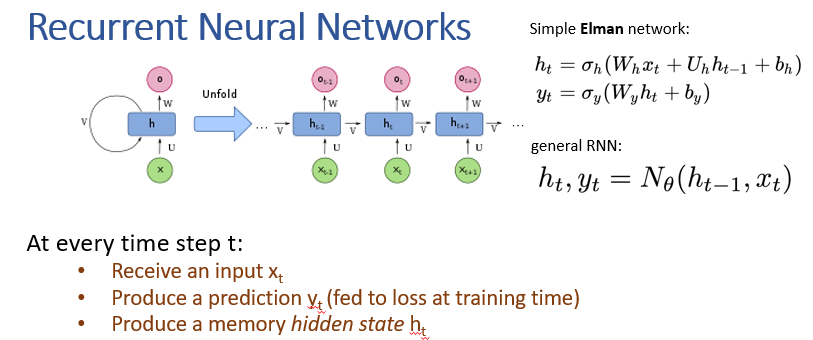

RNN

In [11]:
def RNN(dim,x):
  # Learnable weights in the cell
  # The gates and update operators should consist of a single FC layer 
	Wh = layers.Dense(dim, use_bias=False)
	Wx = layers.Dense(dim)
	# unstacking the time axis
	x = tf.unstack(x,axis=1)
	H = []
	h = tf.zeros_like(Wx(x[0]))
	for i in range(len(x)):
		# Apply the basic step in each time step
		h = Wh(h) +Wx(x[i])		
		H.append(h)
	H = tf.stack(H,axis=1)
	return h, H


# GRU

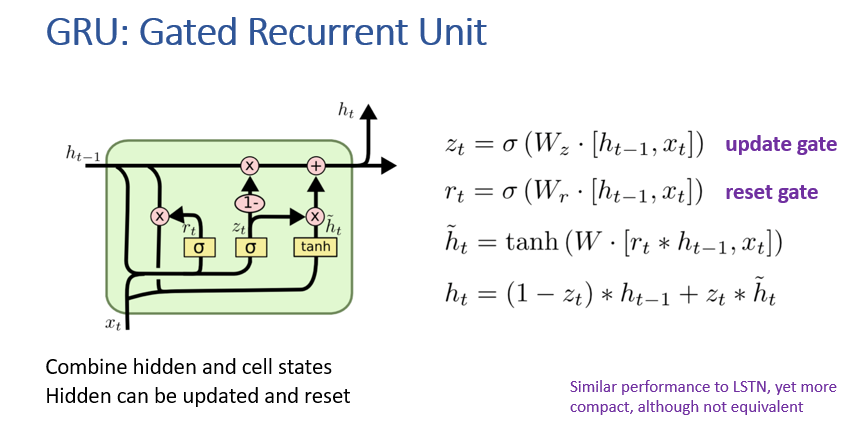

In [12]:
def GRU(dim,x):

	# Learnable weights in the cell
	Wzx = layers.Dense(dim)
	Wzh = layers.Dense(dim, use_bias=False)

	Wrx = layers.Dense(dim)
	Wrh = layers.Dense(dim, use_bias=False)

	Wx = layers.Dense(dim)
	Wh = layers.Dense(dim, use_bias=False)

	# unstacking the time axis
	x = tf.unstack(x,axis=1)
	
	H = []

	h = tf.zeros_like(Wx(x[0]))

	for i in range(len(x)):
		z = tf.sigmoid(Wzx(x[i]) + Wzh(h))
		r =  tf.sigmoid(Wrx(x[i]) + Wrh(h))
		ht = tf.tanh(Wh((r * h)) + Wx(x[i]))
		h = (1-z) * h + z * ht

		H.append(h)

	H = tf.stack(H,axis=1)

	return h, H

# RNN Results:

Run each of these two recurrent network architectures . Hidden-state dimension should be between 64-128 for the lowest test error.

Create model RNN with dim = 128 

In [22]:
epochs = 15

In [23]:
model = bulid_model(input , is_RNN = True ,dim = 128 )
model = train_model(model,'my_rnn_dim_128')

Training
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     10139900    input_1[0][0]                    
__________________________________________________________________________________________________
tf.unstack_2 (TFOpLambda)       [(None, 100), (None, 0           embedding[0][0]                  
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          12928       tf.unstack_2[0][0]               
                                                                 tf.unstack_2[0][0]

Plot ROC Curve

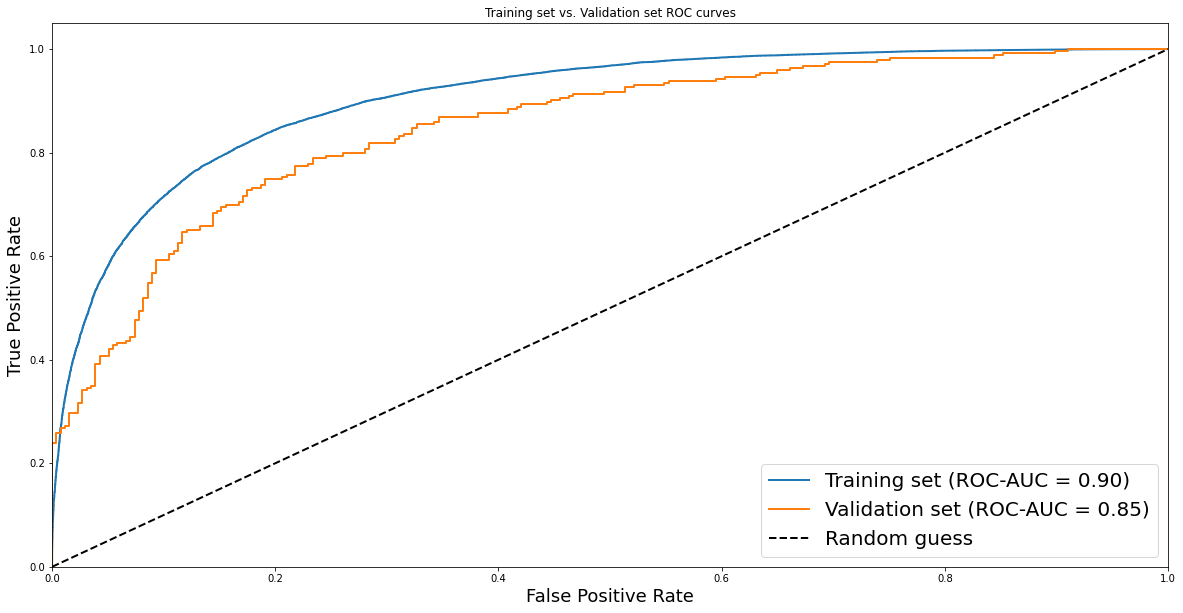

In [24]:
pred = [model.predict(train_texts), model.predict(test_texts)]
actual = [train_labels, test_labels]
stats(pred, actual)

Show 5 first sentences from validation set, and the results (accuracy,f1 score,auc)

In [25]:
show_prediction(model,test_texts,test_ascii,test_labels)

Example Predictions:
--------------------
['this', 'hbo', 'original', 'is', 'pretty', 'straightforward', 'and', 'pretty', 'dumb', 'armand', 'assante', 'once', 'again', 'doing', 'poor', 'stallone', 'imitation', 'is', 'ray', 'wellman', 'ex', 'con', 'just', 'out', 'on', 'parole', 'all', 'he', 'wants', 'is', 'his', 'old', 'girlfriend', 'lacy', 'played', 'by', 'young', 'marcia', 'gay', 'harden', 'back', 'unfortunately', 'for', 'ray', 'lacy', 'has', 'hooked', 'up', 'with', 'stalwart', 'elliot', 'played', 'by', 'sam', 'neill', 'further', 'complicating', 'matters', 'is', 'that', 'ray', 'old', 'cell', 'buddies', 'want', 'some', 'favors', 'and', 'they', 'kidnap', 'lacy', 'to', 'make', 'sure', 'they', 'happen', 'ray', 'and', 'elliot', 'team', 'up', 'despite', 'mutual', 'dislike', 'what', 'follows', 'is', 'violent', 'and', 'slow', 'but', 'marcia', 'gay', 'harden', 'shows', 'us', 'why', 'she', 'would', 'win', 'oscar', 'in', 'the', 'future', 'she', 'not', 'as', 'polished', 'here', 'but', 'her', 'raw

Show 5 first sentences from my test set, and the results (accuracy,f1 score,auc)

In [26]:
show_prediction(model,my_test_texts,my_test_ascii,my_labels)

Example Predictions:
--------------------
['This', 'movie', 'is', 'amazing']
[0.59350574]
Positive 1
--------------------
--------------------
['I', 'cant', 'recommend', 'this', 'movie', 'highly', 'enough']
[0.44046244]
Negative 1
--------------------
--------------------
['I', 'loved', 'this', 'one']
[0.5743084]
Positive 1
--------------------
--------------------
['Boring', 'not', 'worth', 'the', 'time']
[0.25164303]
Negative 0
--------------------
--------------------
['I', 'had', 'expectations', 'I', 'thought', 'it', 'would', 'be', 'interesting', 'but', 'I', 'was', 'disappointed']
[0.6438073]
Positive 0
--------------------
Accuracy score: 0.6667
F1 score: 0.75
ROC AUC score: 0.625


In [27]:
model.save('/content/drive/MyDrive/Deep Learning/imp_rnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/imp_rnn/assets


In [ ]:
models.load_model('/content/drive/MyDrive/Deep Learning/rnn')

Create model RNN with dim = 64

In [28]:
model = bulid_model(input , is_RNN = True ,dim = 64 )
model = train_model(model,'my_rnn_dim_64')

Training
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     10139900    input_1[0][0]                    
__________________________________________________________________________________________________
tf.unstack_3 (TFOpLambda)       [(None, 100), (None, 0           embedding[0][0]                  
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           6464        tf.unstack_3[0][0]               
                                                                 tf.unstack_3[0][0]

ROC Curve of RNN with dim = 64

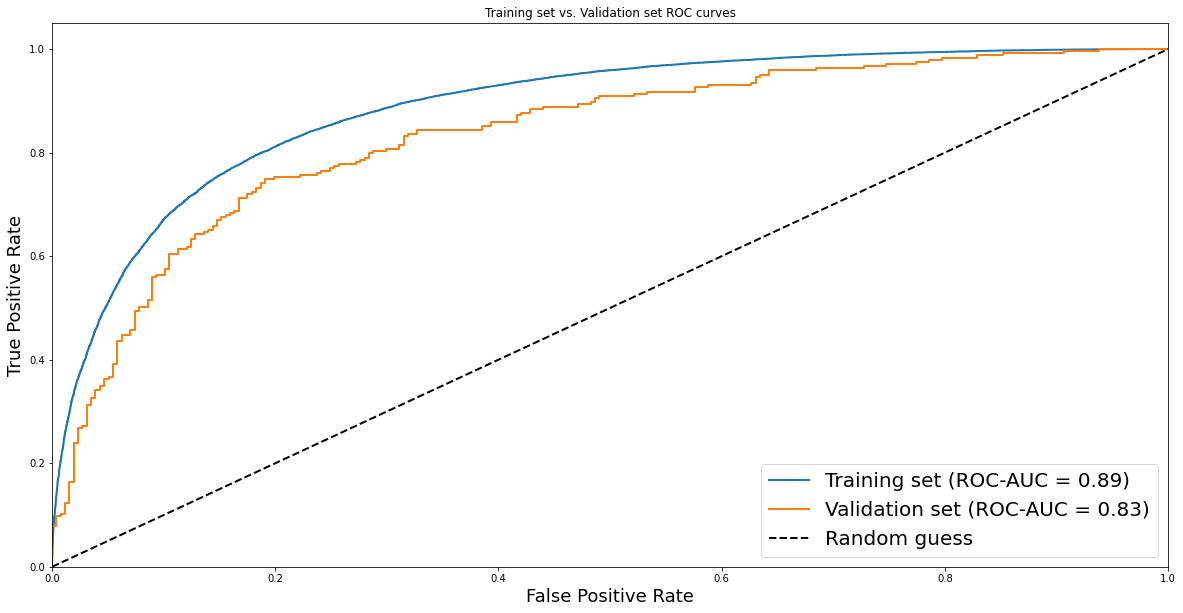

In [29]:
pred = [model.predict(train_texts), model.predict(test_texts)]
actual = [train_labels, test_labels]
stats(pred, actual)

In [30]:
model.save('/content/drive/MyDrive/Deep Learning/64rnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/64rnn/assets


In [ ]:
models.load_model('/content/drive/MyDrive/Deep Learning/64rnn')

Show 5 first sentences from validation set, and the results (accuracy,f1 score,auc)

In [31]:
show_prediction(model,test_texts,test_ascii,test_labels)

Example Predictions:
--------------------
['this', 'hbo', 'original', 'is', 'pretty', 'straightforward', 'and', 'pretty', 'dumb', 'armand', 'assante', 'once', 'again', 'doing', 'poor', 'stallone', 'imitation', 'is', 'ray', 'wellman', 'ex', 'con', 'just', 'out', 'on', 'parole', 'all', 'he', 'wants', 'is', 'his', 'old', 'girlfriend', 'lacy', 'played', 'by', 'young', 'marcia', 'gay', 'harden', 'back', 'unfortunately', 'for', 'ray', 'lacy', 'has', 'hooked', 'up', 'with', 'stalwart', 'elliot', 'played', 'by', 'sam', 'neill', 'further', 'complicating', 'matters', 'is', 'that', 'ray', 'old', 'cell', 'buddies', 'want', 'some', 'favors', 'and', 'they', 'kidnap', 'lacy', 'to', 'make', 'sure', 'they', 'happen', 'ray', 'and', 'elliot', 'team', 'up', 'despite', 'mutual', 'dislike', 'what', 'follows', 'is', 'violent', 'and', 'slow', 'but', 'marcia', 'gay', 'harden', 'shows', 'us', 'why', 'she', 'would', 'win', 'oscar', 'in', 'the', 'future', 'she', 'not', 'as', 'polished', 'here', 'but', 'her', 'raw

Show 5 first sentences from my test set, and the results (accuracy,f1 score,auc)

In [32]:
show_prediction(model,my_test_texts,my_test_ascii,my_labels)

Example Predictions:
--------------------
['This', 'movie', 'is', 'amazing']
[0.50656605]
Positive 1
--------------------
--------------------
['I', 'cant', 'recommend', 'this', 'movie', 'highly', 'enough']
[0.41895914]
Negative 1
--------------------
--------------------
['I', 'loved', 'this', 'one']
[0.4987315]
Negative 1
--------------------
--------------------
['Boring', 'not', 'worth', 'the', 'time']
[0.29164532]
Negative 0
--------------------
--------------------
['I', 'had', 'expectations', 'I', 'thought', 'it', 'would', 'be', 'interesting', 'but', 'I', 'was', 'disappointed']
[0.5592504]
Positive 0
--------------------
Accuracy score: 0.5
F1 score: 0.5714
ROC AUC score: 0.625


# GRU Results

Create model GRU with dim = 64

In [33]:
model = bulid_model(input , is_RNN = False ,dim = 64 )
model = train_model(model,'gru_dim_64')

Training
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     10139900    input_1[0][0]                    
__________________________________________________________________________________________________
tf.unstack_4 (TFOpLambda)       [(None, 100), (None, 0           embedding[0][0]                  
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 64)           6464        tf.unstack_4[0][0]               
                                                                 tf.unstack_4[0][0]

ROC Curve of GRU with dim = 64 

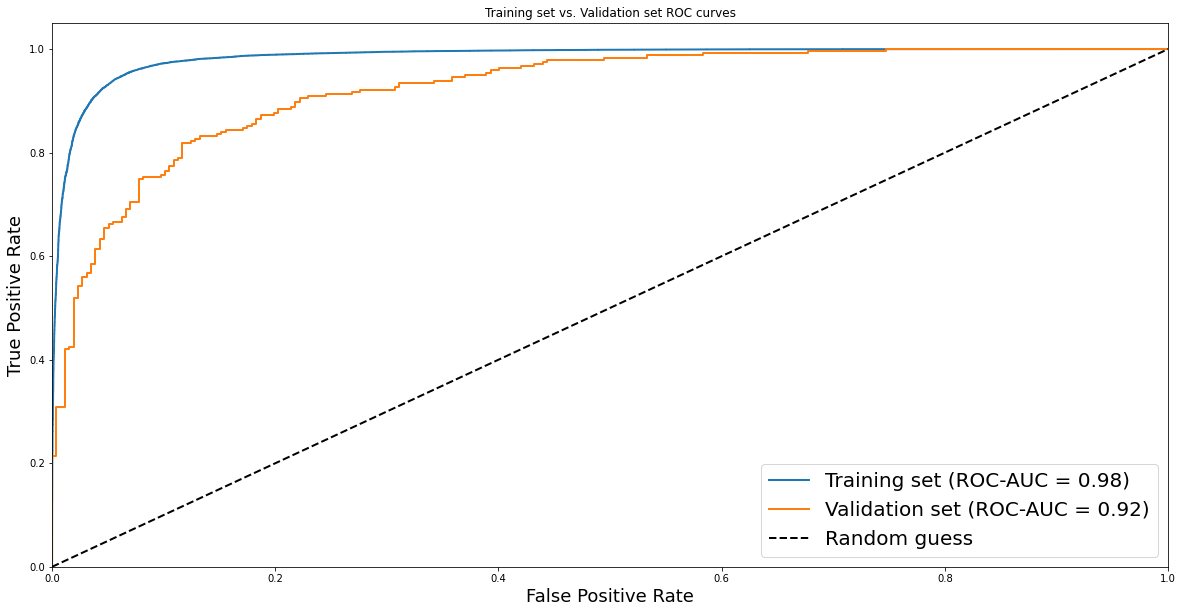

In [34]:
pred = [model.predict(train_texts), model.predict(test_texts)]
actual = [train_labels, test_labels]
stats(pred, actual)

Show GRU with dim = 64 predictions and results

Show 5 first sentences from validation set, and the results (accuracy,f1 score,auc)

In [35]:
show_prediction(model,test_texts,test_ascii,test_labels)

Example Predictions:
--------------------
['this', 'hbo', 'original', 'is', 'pretty', 'straightforward', 'and', 'pretty', 'dumb', 'armand', 'assante', 'once', 'again', 'doing', 'poor', 'stallone', 'imitation', 'is', 'ray', 'wellman', 'ex', 'con', 'just', 'out', 'on', 'parole', 'all', 'he', 'wants', 'is', 'his', 'old', 'girlfriend', 'lacy', 'played', 'by', 'young', 'marcia', 'gay', 'harden', 'back', 'unfortunately', 'for', 'ray', 'lacy', 'has', 'hooked', 'up', 'with', 'stalwart', 'elliot', 'played', 'by', 'sam', 'neill', 'further', 'complicating', 'matters', 'is', 'that', 'ray', 'old', 'cell', 'buddies', 'want', 'some', 'favors', 'and', 'they', 'kidnap', 'lacy', 'to', 'make', 'sure', 'they', 'happen', 'ray', 'and', 'elliot', 'team', 'up', 'despite', 'mutual', 'dislike', 'what', 'follows', 'is', 'violent', 'and', 'slow', 'but', 'marcia', 'gay', 'harden', 'shows', 'us', 'why', 'she', 'would', 'win', 'oscar', 'in', 'the', 'future', 'she', 'not', 'as', 'polished', 'here', 'but', 'her', 'raw

Show 5 first sentences from my test set, and the results (accuracy,f1 score,auc)

In [36]:
show_prediction(model,my_test_texts,my_test_ascii,my_labels)

Example Predictions:
--------------------
['This', 'movie', 'is', 'amazing']
[0.97527677]
Positive 1
--------------------
--------------------
['I', 'cant', 'recommend', 'this', 'movie', 'highly', 'enough']
[0.00666757]
Negative 1
--------------------
--------------------
['I', 'loved', 'this', 'one']
[0.9776049]
Positive 1
--------------------
--------------------
['Boring', 'not', 'worth', 'the', 'time']
[0.00479398]
Negative 0
--------------------
--------------------
['I', 'had', 'expectations', 'I', 'thought', 'it', 'would', 'be', 'interesting', 'but', 'I', 'was', 'disappointed']
[0.00661436]
Negative 0
--------------------
Accuracy score: 0.8333
F1 score: 0.8571
ROC AUC score: 1.0


# Task 2

Another approach is to process each word by a small number of FC layers to obtain a value (“sub prediction score”) and then sum up all these values to obtain a final prediction, thus coping with data of variable length. A sigmoid activation should be applied on the final output prediction to constrain it to [0,1]. 
Here again experiment with the number of FCs layers and their dim ans report the best performing one. 


In [ ]:
def bulid_model_sub_score(input,dim):
  x = layers.Dense(128)(input)
  x = layers.Dense(16, activation='relu')(x)
  sub_score = layers.Dense(1,name="sub_score",activation='sigmoid')(x)
  x = K.sum(sub_score,axis=1)
  x = layers.Dense(1, activation='sigmoid')(x)
  predictions = x
  model = models.Model(inputs=sequences, outputs=predictions)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])
  return model

In [85]:
model = bulid_model_sub_score(input,64)

In [86]:
model_sub = train_model(model,"sub")

Training
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          10139900  
_________________________________________________________________
dense_34 (Dense)             (None, 100, 128)          12928     
_________________________________________________________________
dense_35 (Dense)             (None, 100, 16)           2064      
_________________________________________________________________
sub_score (Dense)            (None, 100, 1)            17        
_________________________________________________________________
tf.math.reduce_sum_19 (TFOpL (None, 1)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)           

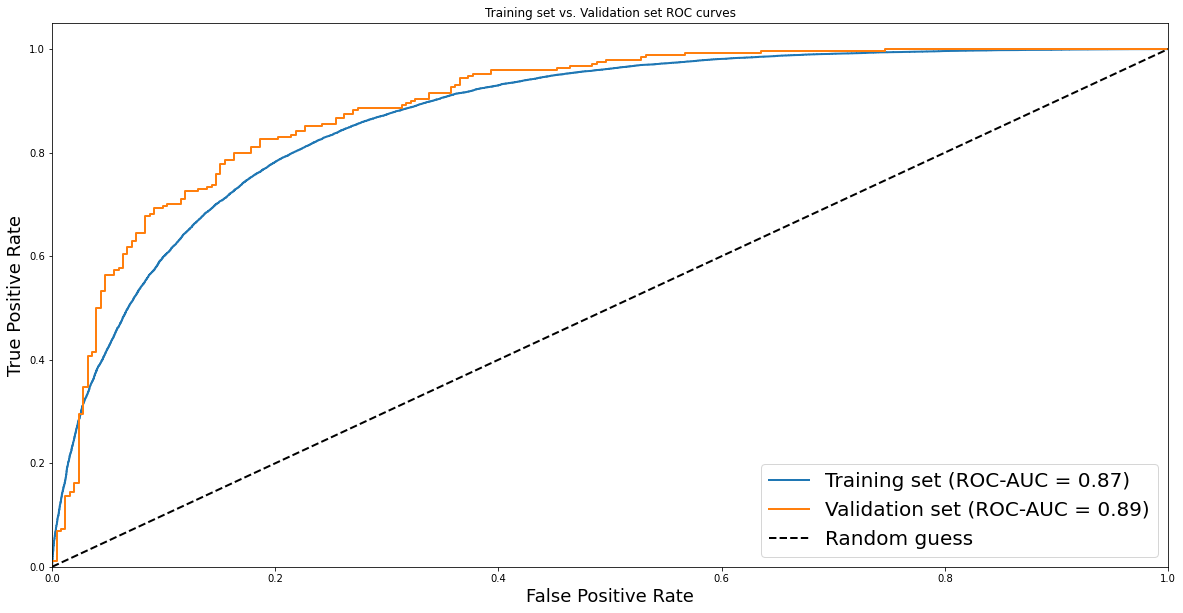

In [87]:
pred = [model_sub.predict(train_texts), model_sub.predict(test_texts)]
actual = [train_labels, test_labels]
stats(pred, actual)

In [88]:
show_words_scores(model_sub,my_test_texts,my_test_ascii,my_labels)

Example Predictions:
--------------------
This 0.0004223161959089339

movie 1.209144920721883e-05

is 0.001191847026348114

amazing 1.6441930711152963e-05

Positive 1
--------------------
--------------------
I 1.6565861642447999e-06

cant 6.864743045298383e-05

recommend 3.7453403933795926e-08

this 0.00013868676614947617

movie 0.00010089482384501025

highly 0.00014803143858443946

enough 2.287507605558403e-08

Positive 1
--------------------
--------------------
I 0.07947801053524017

loved 3.2623276638332754e-05

this 3.7453403933795926e-08

one 0.0016793844988569617

Positive 1
--------------------
--------------------
Boring 1.209144920721883e-05

not 5.591098783952475e-07

worth 7.018509495537728e-05

the 0.0017538771498948336

time 1.94239619304426e-05

Negative 0
--------------------
--------------------
I 4.3294221541145816e-05

had 0.029746511951088905

expectations 0.0005097261164337397

I 0.0006210884894244373

thought 3.7453403933795926e-08

it 0.0005097261164337397

woul

In [89]:
show_words_scores(model_sub,test_texts,test_ascii,test_labels)

Example Predictions:
--------------------
extremely 0.0004223161959089339

good 1.209144920721883e-05

cinematic 0.001191847026348114

story 1.6441930711152963e-05

of 1.2735922894080431e-07

gay 0.00013016581942792982

embittered 5.867602226317103e-07

former 1.9708457088540854e-08

teen 5.252319024151575e-09

star 1.3633529306389391e-05

now 0.16585080325603485

waiting 0.00014803143858443946

tables 1.2322750819748762e-08

the 4.3294221541145816e-05

sexual 0.00013785233022645116

ambiguities 5.8745392550463293e-08

are 3.7453403933795926e-08

explored 1.1518693554535275e-07

here 6.971877724026854e-07

realistically 0.16778303682804108

and 1.7720429923429037e-07

with 1.7065998463294818e-06

an 2.479752220096998e-05

actual 3.7453403933795926e-08

human 0.20844556391239166

face 3.014733351847099e-08

this 0.003196883713826537

and 2.620945416254017e-08

throw 2.015264470855982e-07

in 0.00014803143858443946

serial 0.1213006004691124

killer 3.7453403933795926e-08

on 0.001383626

# Task 3

Let the final layer produce 2 values (instead of 1) for each word and use the additional scalar as a weight for summing the sub scores. Use a softmax to map the weights into a set of non-negative sum-one weights and run and report the same tests as in Task 2 above. 


In [78]:
def build_sub_score_model(input):
  x = layers.Dense(128)(input)
  x = layers.Dense(16, activation='relu')(x)
  sub_score = layers.Dense(2,name="sub_score",activation='sigmoid')(x)
  sub_score = tf.keras.activations.softmax(sub_score, axis=-1)
  x = K.sum(sub_score,axis=1)
  x = layers.Dense(1, activation='sigmoid')(x)
  predictions = x
  model_3 = models.Model(inputs=sequences, outputs=predictions)
  model_3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])
  return model_3

In [79]:
model_3 = build_sub_score_model(input)
model_3 = train_model(model_3,"sum_model")

Training
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     10139900    input_1[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 100, 128)     12928       embedding[0][0]                  
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 100, 16)      2064        dense_28[0][0]                   
__________________________________________________________________________________

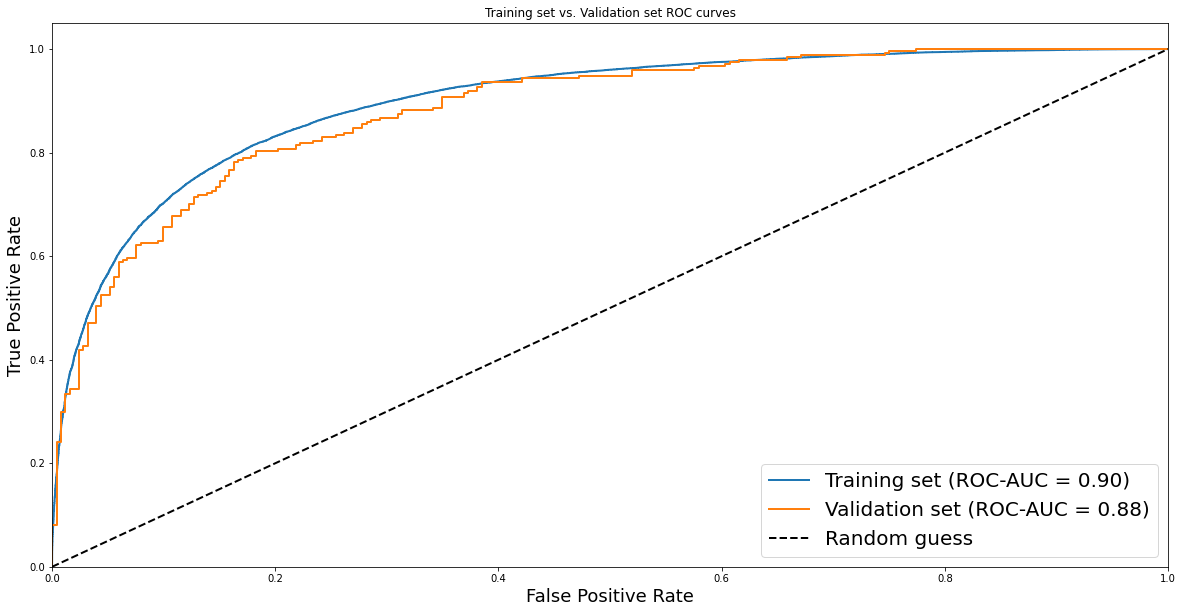

In [80]:
pred = [model_3.predict(train_texts), model_3.predict(test_texts)]
actual = [train_labels, test_labels]
stats(pred, actual)

Show results of my test set

In [81]:
show_words_scores(model_3,my_test_texts,my_test_ascii,my_labels)

Example Predictions:
--------------------
This 0.9460589078080375

movie 1.823777198791504

is 1.0486497581005096

amazing 0.007566207583295181

Positive 1
--------------------
--------------------
I 1.2799495458602905

cant 1.835557758808136

recommend 1.9923303127288818

this 1.011188581585884

movie 0.8256320059299469

highly 0.2529417199548334

enough 0.6571245789527893

Positive 1
--------------------
--------------------
I 1.1927710324525833

loved 0.030170877173077315

this 1.9923303127288818

one 0.4004589939304424

Positive 1
--------------------
--------------------
Boring 1.823777198791504

not 0.46824405749794096

worth 0.2516891956979737

the 1.1645564138889313

time 0.3470552921498893

Negative 0
--------------------
--------------------
I 0.7417919631116092

had 0.6914840147946961

expectations 0.35614229179918766

I 0.46057990880217403

thought 1.9923303127288818

it 0.35614229179918766

would 0.3617224246263504

be 1.1369105577468872

interesting 1.0108301350846887

bu

Show results of test set

In [82]:
show_words_scores(model_3,test_texts,test_ascii,test_labels)

Example Predictions:
--------------------
extremely 0.9460589078080375

good 1.823777198791504

cinematic 1.0486497581005096

story 0.007566207583295181

of 0.38161372765898705

gay 0.8817484963401512

embittered 0.9933736164093716

former 1.7140259742736816

teen 0.9807920083403587

star 0.6862422972917557

now 1.3722720742225647

waiting 0.2529417199548334

tables 0.9919005958363414

the 0.7417919631116092

sexual 0.902956546311699

ambiguities 0.776458497857675

are 1.9923303127288818

explored 0.19027237565023825

here 0.07590580266673896

realistically 0.8031473951414227

and 1.0546872913837433

with 1.0344427414238453

an 0.5933472258184338

actual 1.9923303127288818

human 1.0002518214168958

face 0.3092915534507483

this 1.007205336354673

and 1.1352853029966354

throw 0.4848388305399567

in 0.2529417199548334

serial 1.000433122040704

killer 1.9923303127288818

on 1.9826493859291077

the 0.3951457813382149

loose 1.0004597466322593

and 1.9923303127288818

you 0.2529417199548

In [44]:
model_3.save('/content/drive/MyDrive/Deep Learning/imp2_task3_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/imp2_task3_model/assets


In [ ]:
m = models.load_model('/content/drive/MyDrive/Deep Learning/task3_model')

# Task 4

# self-attention layer

Write a restricted self-attention layer which queries every word with its closest 5 words on each side. This layer should have a single head and learnable query and keys matrices. 

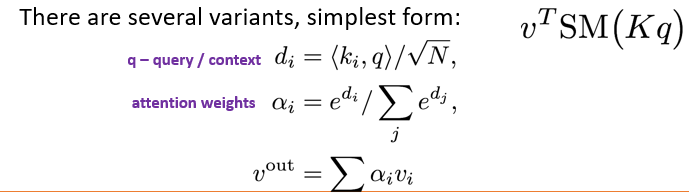

In [45]:
def restricted_attention(x,k):
  dim = x.shape[2]
  Wq = layers.Dense(dim)
  Wk = layers.Dense(dim)
  wk = Wk(x)
  paddings = tf.constant([[0, 0,], [k, k], [0,0]])
  pk = tf.pad(wk, paddings) 
  pv = tf.pad(x, paddings) 
  keys = []
  vals = []
  for i in range(-k,k+1):
    keys.append(tf.roll(pk,i,1))
    vals.append(tf.roll(pv,i,1))

  keys = tf.stack(keys,2)
  keys = keys[:,k:-k,:,:]
  vals = tf.stack(vals,2)
  vals = vals[:,k:-k,:,:]

  pq = tf.pad(Wq(input), paddings) 
  query =[]
  for i in range(-k,k+1):
    query.append(tf.roll(pq,i,1))
  query = tf.stack(query,2)
  query = query[:,k:-k,:,:]
  dot_product = query*keys/ K.sqrt(K.cast(dim, dtype=K.floatx()))
  e = K.exp(dot_product - K.max(dot_product, axis=-1, keepdims=True))
  attention = e / K.sum(e, axis=-1, keepdims=True)
  atten_weights = attention*vals
  val_out = K.sum(atten_weights,axis=2)

  return x+val_out

In [46]:
att_layer = restricted_attention(input,5)

# Task 5

Use this restricted attention layer as the first layer of Task 3 and repeat the experiments above; two reviews, one correctly predicted, one wrong, print the sub prediction scores per each word, explain the results - how they differ from before. Describe the main principle difference in the predictions abilities that this layer adds to the network and how it can be seen in the results.


In [90]:
def build_model_task5():  
  x = layers.Dense(128)(att_layer)
  x = layers.Dense(16, activation='relu')(x)
  sub_score = layers.Dense(2,name="sub_score",activation='sigmoid')(x)
  sub_score = tf.keras.activations.softmax(sub_score, axis=-1)
  x = K.sum(sub_score,axis=1)
  x = layers.Dense(1, activation='sigmoid')(x)
  predictions = x
  model_5 = models.Model(inputs=sequences, outputs=predictions)
  model_5.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])
  return model_5

In [91]:
model_5 = build_model_task5()

In [92]:
model_5 = train_model(model_5,'model_5')

Training
Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     10139900    input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100, 100)     10100       embedding[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100, 100)     10100       embedding[0][0]                  
__________________________________________________________________________________

In [50]:
model_5.save('/content/drive/MyDrive/Deep Learning/imp_my_modelatt')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/imp_my_modelatt/assets


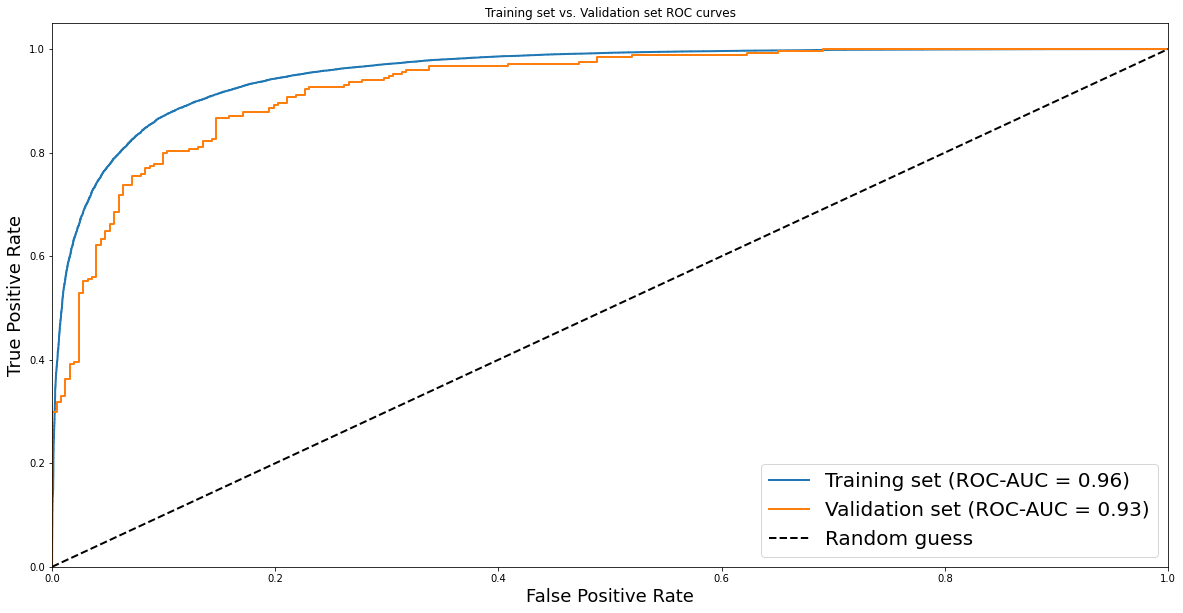

In [93]:
pred = [model_5.predict(train_texts), model_5.predict(test_texts)]
actual = [train_labels, test_labels]
stats(pred, actual)

In [94]:
show_words_scores(model_5,my_test_texts,my_test_ascii,my_labels)

Example Predictions:
--------------------
This 0.994184136390686

movie 0.6192785799503326

is 0.482318595983088

amazing 0.4971533864736557

Positive 1
--------------------
--------------------
I 0.31996229849755764

cant 0.7433578073978424

recommend 0.9995439946651459

this 0.6454012244939804

movie 1.860028624534607

highly 1.079694151878357

enough 0.2852265313267708

Positive 1
--------------------
--------------------
I 0.5464983582496643

loved 0.9599781036376953

this 0.7846314311027527

one 0.2868731766939163

Positive 1
--------------------
--------------------
Boring 1.1153807938098907

not 1.3042886853218079

worth 1.0846204161643982

the 1.4919089674949646

time 0.5084910094738007

Negative 0
--------------------
--------------------
I 0.19877048209309578

had 0.6074221730232239

expectations 0.9964616000652313

I 0.5945707410573959

thought 0.8110296130180359

it 0.9962018728256226

would 0.9965084791183472

be 1.0751320719718933

interesting 0.29307248070836067

but 0.9

In [95]:
show_words_scores(model_5,test_texts,test_ascii,test_labels)

Example Predictions:
--------------------
extremely 0.994184136390686

good 0.6192785799503326

cinematic 0.482318595983088

story 0.4971533864736557

of 0.9973600804805756

gay 0.34531690180301666

embittered 0.11813789419829845

former 0.013832610566169024

teen 0.12705427035689354

star 0.15258150547742844

now 0.13760650902986526

waiting 1.0955869257450104

tables 0.027067498303949833

the 0.25726479943841696

sexual 0.11449234932661057

ambiguities 0.23492636531591415

are 0.754149317741394

explored 0.9662461876869202

here 1.1360308527946472

realistically 1.54596346616745

and 0.6183058619499207

with 0.5388319939374924

an 0.9759838879108429

actual 1.0256592631340027

human 0.8623184636235237

face 0.4755231589078903

this 0.8744134902954102

and 0.5565946102142334

throw 1.0749075412750244

in 0.9973600804805756

serial 0.16594453155994415

killer 0.821296215057373

on 0.346269890666008

the 0.3866516053676605

loose 0.24967756867408752

and 0.9121055603027344

you 1.057884